In [1]:
import os
import sys

import numpy as np
import scipy
import torch
# import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import copy
import random
import gc
import math

from torch import nn

# NOTE: change this to fit your platform
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prepare dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install transformers
!pip install cartopy
# !pip install sentencepiece

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/6.8610_proj' # Change this to your directory
df = pd.read_csv(os.path.join(path, 'majorcities.csv'), index_col=0).dropna(subset='population')
df = df[df.population > 60000]

num_class = 100
major_cnty = df.groupby('country_id').count().sort_values('city', ascending=False).index.values[:num_class]
df_major = df[df.country_id.isin(list(major_cnty))].drop_duplicates(['city', 'admin_name'])
df_major



,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id.1,country_id
id,,,,,,,,,,,,
1392685764,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37732000.0,1392685764,20
1360771077,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077,39
1356872604,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604,88
1156237133,Guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133,45
1356226629,Mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629,88
...,...,...,...,...,...,...,...,...,...,...,...,...
1600304725,Katueté,Katuete,-24.2481,-54.7575,Paraguay,PY,PRY,Canindeyú,NaN,62319.0,1600304725,52
1840003970,Dearborn Heights,Dearborn Heights,42.3164,-83.2769,United States,US,USA,Michigan,NaN,62334.0,1840003970,42
1643910130,Tuapse,Tuapse,44.1044,39.0772,Russia,RU,RUS,Krasnodarskiy Kray,minor,62269.0,1643910130,19


In [5]:
df_major.admin_name = df_major.apply((lambda x: ", ".join([x.city, x.admin_name]) if type(x.admin_name)!=float else x.city), axis=1)
df_major[df_major.city=='London']

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id.1,country_id
id,,,,,,,,,,,,
1826645935,London,London,51.5072,-0.1275,United Kingdom,GB,GBR,"London, London, City of",primary,11262000.0,1826645935,95
1124469960,London,London,42.9836,-81.2497,Canada,CA,CAN,"London, Ontario",NaN,383822.0,1124469960,33


## Intervention

### Load Data

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

def load_data(d, bs=64, feat_name='hidden_state',seed=0):
  def compose_dataset(tokenizer, names, labels, coord):
      tokenize_res = tokenizer(list(names), truncation=True, max_length=8, padding=True, return_tensors='pt')
      input_ids, mask = tokenize_res.input_ids, tokenize_res.attention_mask
      ds = TensorDataset(input_ids, mask, torch.tensor(labels, dtype=torch.long), torch.tensor(coord, dtype=torch.float32))
      return ds

  def collate_fn(batch):
      ids, mask, label, coord= [],[],[],[]
      for s in batch:
          ids.append(s[0])
          mask.append(s[1])
          label.append(s[2])
          coord.append(s[3])
      inputs = {'input_ids':torch.stack(ids), 'mask':torch.stack(mask), 'label':torch.stack(label), 'coord':torch.stack(coord)}
      return inputs

  def collate_fn_hiddens(batch):
      ids, mask, hidden, label, coord= [],[],[],[],[]
      for s in batch:
          emb, token, m = d[s[0].item()]
          hidden.append(emb)
          ids.append(token)
          mask.append(m)
          label.append(s[1])
          coord.append(s[2])
      inputs = {'input_ids':torch.stack(ids), 'mask':torch.stack(mask), feat_name:torch.stack(hidden) ,'label':torch.stack(label), 'coord':torch.stack(coord)}
      return inputs

  # Random
  names, label = df_major.index.values, df_major.loc[:,["country_id","lat",'lng']].values
  xt, xv, yt, yv = train_test_split(names, label, test_size=0.2, random_state=seed, stratify=label[:,0])

  # By country
  # c_out = ['China']
  # xt, xv = df_major[~df_major.country.isin(c_out)].index.values, df_major[df_major.country.isin(c_out)].index.values
  # yt, yv = df_major.loc[xt,["country_id","lat",'lng']].values, df_major.loc[xv,["country_id","lat",'lng']].values

  train_ds = TensorDataset(torch.tensor(xt, dtype=torch.long), torch.tensor(yt[:,0], dtype=torch.long), torch.tensor(yt[:,1:], dtype=torch.float32))
  val_ds = TensorDataset(torch.tensor(xv, dtype=torch.long), torch.tensor(yv[:,0], dtype=torch.long), torch.tensor(yv[:,1:], dtype=torch.float32))
  train_loader =  DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn_hiddens)
  val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn_hiddens)

  return train_loader, val_loader


In [20]:
# Select LM
model_name = 'GPT-Neo_sent'
# model_name = 'DeBERTa_sent'
mask = torch.load(os.path.join(path, f'hidden_states/{model_name}/masks.pt'))
emb = torch.load(os.path.join(path, f'hidden_states/{model_name}/h24.pt'))
id = torch.load(os.path.join(path, f'hidden_states/{model_name}/cid.pt'))
token = torch.load(os.path.join(path, f'hidden_states/{model_name}/tokens.pt'))
d = {id[i].item():(emb[i], token[i], mask[i]) for i in range(id.shape[0])}

del emb

### Linear Regression using MSE

In [9]:
from sklearn.linear_model import LinearRegression

xids = df_major.index.values
X = np.stack([d[cid][0].mean(0) for cid in xids])
coord=df_major.loc[xids][['lat','lng']].values
lreg = LinearRegression()
lreg.fit(X,coord)

LinearRegression()

Text(0.5, 1.0, 'GPT-Neo, layer 12')

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


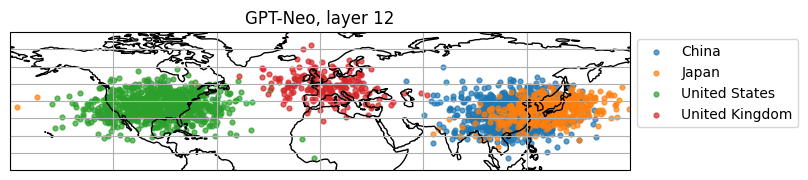

In [12]:
import cartopy.crs as ccrs
cty=['China','Japan','United States','United Kingdom']
fig,ax=plt.subplots(figsize=(8 , 6), subplot_kw={'projection': ccrs.PlateCarree()})
# fig.colorbar(c, ax=ax)
for c in cty:
  cids= df_major[df_major.country==c].index.values
  x=[d[cid][0].mean(0) for cid in cids]
  x = np.stack(x)
  coords=lreg.predict(x)
  ax.scatter(coords[:,1],coords[:,0],label=c,s=12,alpha=0.7)
  ax.set_ylim(0, 80)
ax.coastlines()
ax.gridlines()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title("GPT-Neo, layer 12")




### Regression Loss v.s. Model Depth

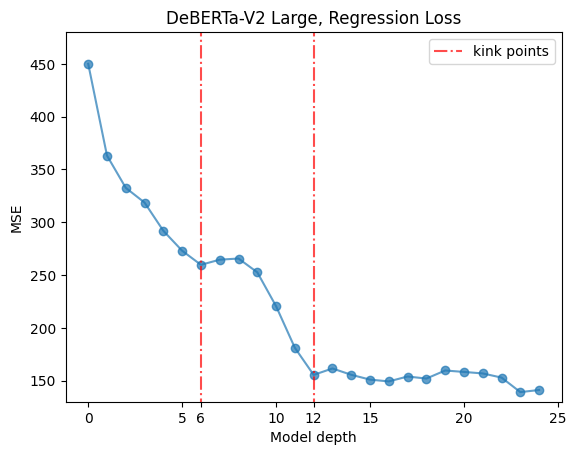

In [26]:
from sklearn.metrics import mean_squared_error

def read_emb(model_name = 'g', h=24):
  model_name = 'DeBERTa_sent' if model_name=='b' else 'GPT-Neo_sent'
  mask = torch.load(os.path.join(path, f'hidden_states/{model_name}/masks.pt'))
  emb = torch.load(os.path.join(path, f'hidden_states/{model_name}/h{h}.pt'))
  id = torch.load(os.path.join(path, f'hidden_states/{model_name}/cid.pt'))
  token = torch.load(os.path.join(path, f'hidden_states/{model_name}/tokens.pt'))
  d = {id[i].item():(emb[i], token[i], mask[i]) for i in range(id.shape[0])}
  del emb
  return d

l_depth=np.zeros(24)
for h in range(1,25):
    act_dict = read_emb('b', h)
    X, coord = [],[]
    for k, v in act_dict.items():
      X.append(v[0])
      coord.append(df_major[df_major['id.1']==k][['lat', 'lng']].values)
    del act_dict

    X = np.stack(X, axis=0).mean(1)
    coord = np.stack(coord, axis=0).mean(1)
    lreg = LinearRegression()
    lreg.fit(X,coord)
    y_pred = lreg.predict(X)
    l_depth[h-1] = mean_squared_error(y_pred, coord)
    gc.collect()

plt.plot(range(25), np.concatenate(([450], l_depth)), marker='o', alpha=0.7)
plt.title("DeBERTa-V2 Large, Regression Loss")
plt.xlabel("Model depth")
plt.ylabel("MSE")
plt.vlines([6,12], 0, 800, colors='red', linestyles='dashdot', alpha=0.7, label='kink points')
plt.ylim(130, 480)
plt.xticks([0,5,6,10,12,15,20,25])
plt.legend()

### Load LM

In [11]:
# import sentencepiece
from transformers import AutoTokenizer, DebertaV2Model, RobertaModel
from transformers import AutoTokenizer, GPTNeoModel

def load_bert(layer: int):
  # Load pretrained DeBERTa model
  tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v2-xlarge")
  if layer == 24:
    model = None
  else:
    model = DebertaV2Model.from_pretrained("microsoft/deberta-v2-xlarge").to(device).requires_grad_(False)

    # remove ealier layers for downstream classification
    model.encoder.layer = model.encoder.layer[layer:]
    model.encoder.conv=None
  return tokenizer, model

class ZeroLayer(nn.Module):
   def forward(self, x):
    return torch.zeros(1, device=x.device)


def load_gpt(layer=24):

  tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
  if layer == 24:
    model = None
  else:
    model = GPTNeoModel.from_pretrained("EleutherAI/gpt-neo-1.3B").to(device)
    model.h = model.h[layer:]
    model.wpe=ZeroLayer()
  return tokenizer, model

### Mapping FCNN

In [12]:
class Base(nn.Module):
    def __init__(self, device='cpu', *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.best_model = None
        self.device = device

    def forward(self):
        pass

    def compute_loss(self):
        pass

    def train_all(self, train_iter, val_iter, epochs=20, learning_rate=1e-3):
        # Use Adam to optimize the parameters
        optim = torch.optim.AdamW(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs*2)
        best_val_loss = float('inf')
        # Run the optimization for multiple epochs
        for epoch in tqdm(range(epochs)):
            # Switch the module to training mode
            self.train()
            losses = []
            with tqdm(enumerate(train_iter), desc='train', position=0) as pbar:
                for i, batch in pbar:
                    optim.zero_grad()
                    loss = self.compute_loss(batch)
                    loss.backward()
                    # torch.nn.utils.clip_grad_value_(self.parameters(), 1.)
                    optim.step()
                    losses.append(loss.item())
                    pbar.set_postfix(epoch=epoch, iter=i, loss=sum(losses)/len(losses))


                # Evaluate and track improvements on the validation dataset
                val_loss = self.evaluate(val_iter)
                scheduler.step()
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    self.best_model = copy.deepcopy(self.state_dict())
                epoch_loss = sum(losses)/len(losses)
                print(f'[val] Epoch{epoch}, val_loss={val_loss}')
        return best_val_loss

    def evaluate(self, iterator):
        """Returns the model's loss on a given dataset `iterator`."""
        self.eval()   # switch the module to evaluation mode
        losses = []     # running total of example
        with torch.no_grad():
            for batch in iterator:
                loss = self.compute_loss(batch)
                losses.append(loss.item())
        self.train()
        return sum(losses) / len(losses)


In [32]:
class Classifier(Base):
    def __init__(self, n_class, transformer=None, in_features=1536, hidden_dim=1024, n_layer=1, device='cpu', **kwargs) -> None:
        super().__init__(device=device, **kwargs)
        self.hidden_dim = hidden_dim
        self.n_class = n_class
        self.transformer = transformer
        if self.transformer:
            self.transformer.requires_grad_(False)

        layers, n_in, n_out = [], in_features, in_features
        for i in range(n_layer-1):
            layers.append(nn.Linear(n_in, hidden_dim))
            # layers.append(nn.ReLU())
            # layers.append(nn.BatchNorm1d(hidden_dim))
            if i > 1: layers.append(nn.Dropout(0.3))
            n_in, n_out = hidden_dim, hidden_dim
        layers.append(nn.Linear(n_out, n_class))
        self.linear = nn.Sequential(*layers)
        self.loss_fn = nn.CrossEntropyLoss()
        self.device = device
        self.to(device)

    def get_hidden_states(self, inputs):
        # DeBERTa
        # emb = self.transformer.get_submodule("embeddings")(inputs['input_ids'].to(self.device))
        # # mask = self.encoder.get_attention_mask(inputs['mask'].to(self.device))
        # # print(mask.dtype)
        # rel_pos = self.transformer.encoder.get_rel_pos(emb.to(self.device))
        # prev = inputs.get('hidden_state', emb)
        # out = self.transformer.encoder(prev.to(self.device), inputs['mask'].to(self.device), output_hidden_states=False, relative_pos=rel_pos)
        # h = out.last_hidden_state

        # GPT-Neo
        out = self.transformer(inputs_embeds=inputs['hidden_state'].to(self.device),
                               attention_mask=inputs['mask'].to(self.device),
                               use_cache=False, output_hidden_states=True)
        h = out.hidden_states[-1].detach()
        del out
        return h

    def forward(self, inputs):
        last_hidden_state = inputs.get("last_hidden_state", None)
        if last_hidden_state is None:
            self.eval()
            with torch.no_grad():
                last_hidden_state = self.get_hidden_states(inputs)
            self.train()
        x = (last_hidden_state.to(self.device) * inputs['mask'].unsqueeze(2).to(self.device)).sum(1)
        logit = self.linear(x.to(self.device))
        return logit

    def compute_loss(self, inputs):
        """forward pass and compute loss"""
        pred = self.forward(inputs)
        return self.loss_fn(pred.view(-1, self.n_class), inputs['label'].to(self.device))

    def predict(self, inputs):
        """predict on one minibatch"""
        self.eval()
        with torch.no_grad():
            logit = self.forward(inputs)
            return torch.argmax(logit, -1)



In [33]:
class GeoDist(nn.Module):
    def forward(self, predicted, target,w=1000):
        """Calculate geographical distance given latitude and longitude by Haversine formula"""
        deg_pred = torch.deg2rad(predicted)
        deg_gt = torch.deg2rad(target)
        lat1, lon1, lat2, lon2 = deg_pred[:,0],deg_pred[:,1],deg_gt[:,0],deg_gt[:,1]

        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = (dlat / 2).sin() ** 2 + lat1.cos() * lat2.cos() * (dlon / 2).sin() ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))

        # Radius of the Earth in kilometers (mean value)
        # radius = 6371.0

        # Calculate the distance
        distance = w * c

        return distance.mean(0)


class Regressor(Base):
    def __init__(self, metric, n_class=2, in_features=1536, hidden_dim=1024, n_layer=1,
                 device='cpu', **kwargs) -> None:
        super().__init__(device, **kwargs)
        self.hidden_dim = hidden_dim
        self.n_class = n_class
        layers, n_in, n_out = [], in_features, in_features
        for i in range(n_layer-1):
            layers.append(nn.Linear(n_in, hidden_dim))
            layers.append(nn.ReLU())
            # layers.append(nn.BatchNorm1d(hidden_dim))
            # layers.append(nn.Dropout(0.3))
            n_in, n_out = hidden_dim, hidden_dim
        layers.append(nn.Linear(n_out, n_class))
        self.linear = nn.Sequential(*layers)
        if metric=='geo':self.loss_fn = GeoDist()
        else: self.loss_fn = nn.MSELoss()
        self.device = device
        self.to(device)

    def forward(self, x, mask):
        x=x * torch.unsqueeze(mask, 2)
        return self.linear(x.sum(1))
        # return (180 + self.linear(x.sum(1))) % 360 - 180

    def compute_loss(self, inputs):
        k = 'hidden_state' if 'hidden_state' in inputs.keys() else 'last_hidden_state'
        pred = self.forward(inputs[k].to(self.device), inputs['mask'].to(self.device))

        return self.loss_fn(pred, inputs['coord'].to(self.device))

    def compute_grad(self, x, mask, gt):
        pred = self.forward(x, mask)
        loss = self.loss_fn(pred, gt)
        loss.backward()
        return loss

    def predict(self, inputs):
        """predict on one minibatch"""
        self.eval()
        with torch.no_grad():
            k = 'hidden_state' if 'hidden_state' in inputs.keys() else 'last_hidden_state'
            pred = self.forward(inputs[k].to(self.device), inputs['mask'].to(self.device))
            return pred



In [34]:
class Perturber(nn.Module):
    def __init__(self, in_features=1536, reg=None, cls=None,
                 device='cpu', **kwargs) -> None:
        super().__init__(**kwargs)
        self.regressor = reg
        self.classifier = cls
        self.classifier.requires_grad_(False)
        self.n_features = in_features
        self.perturbed_samples = None
        self.device = device
        self.to(device)

    def perturb(self, train_loader, val_loader, epochs=10, lr=0.1, rand=False):
        self.eval()
        train_samples = list(train_loader)
        random.shuffle(train_samples)
        reg_losses, cls_acc = [], []
        for epoch in tqdm(range(epochs)):
            # Switch the module to training mode
            self.train()
            losses = []
            with tqdm(enumerate(train_samples), desc='train', position=0) as pbar:
                for i, batch in pbar:
                    k = 'hidden_state' if 'hidden_state' in batch.keys() else 'last_hidden_state'
                    x, mask, gt = batch[k],batch['mask'],batch['coord']
                    x = nn.Parameter(x.to(self.device))
                    loss = self.regressor.compute_grad(x, mask.to(self.device), gt.to(self.device))
                    losses.append(loss.item())
                    x_grad = x.grad.detach().cpu() * torch.unsqueeze(mask,2)
                    if rand: x_grad = x_grad.flip([0,2])
                    x_grad /= torch.norm_except_dim(x_grad)
                    batch[k] = x.data.detach().cpu() - lr * x_grad
                    del x, mask, gt

                    pbar.set_postfix(epoch=epoch, iter=i, loss=sum(losses)/len(losses))

                reg_losses.append(sum(losses)/len(losses))
                # Evaluate and track improvements on the validation dataset
                if epoch %1==0:
                    val_acc = self.evaluate(train_samples)
                    # print(f'[val] Epoch{epoch}, val_acc={val_acc}')
                    cls_acc.append(val_acc.item())

        self.perturbed_samples = train_samples
        return reg_losses, cls_acc

    def perturb_sample(self, x, mask, tgt, epochs=10, lr=0.1):
        x = nn.Parameter(copy.deepcopy(x).to(self.device))
        opt = torch.optim.Adam([x], lr=lr)
        # best = None
        # best_loss = float('inf')
        for epoch in (range(epochs)):
            loss = self.regressor.compute_grad(x.to(self.device), mask.to(self.device), tgt.to(self.device))
            opt.step()
            opt.zero_grad()
            l = loss.item()
            print(l)
        return x.data.detach().cpu()


    def evaluate(self, samples):
        corr, total = 0,0
        for sample in samples:
            pred = self.classifier.predict(sample).cpu()
            corr += (pred == sample['label']).float().sum()
            total += pred.shape[0]
        return corr / total









### Training

In [24]:
import gc
torch.cuda.empty_cache()
gc.collect()

34

In [35]:
# tokenizer, model = load_gpt(24)
clf = Classifier(100,in_features=2048, n_layer=1, hidden_dim=2, transformer=model, device=device)
# Load pretrained classification layer
clf.linear = torch.load(os.path.join(path, 'gpt_cls_lin.pth'),map_location=device)

In [ ]:
# Evaluate classification accuracy
train_loader, val_loader = load_data(d, 256,'last_hidden_state')

correct,total=0,0
for x in val_loader:
  pred = clf(x).max(-1)[1].cpu()
  correct += (pred==x['label']).float().sum()
  # print(pred)
  total += x['label'].shape[0]
correct/total

tensor(0.8478)

In [ ]:
# torch.save(clf, '/content/drive/MyDrive/Colab Notebooks/6.8610_proj/cls.pth')
# torch.save(clf.linear, '/content/drive/MyDrive/Colab Notebooks/6.8610_proj/gpt_cls_lin.pth')

In [59]:
# Probe model
reg = Regressor(metric='mse', in_features=2048, n_layer=2, hidden_dim=128, device=device)
train_loader, val_loader = load_data(d, 256, "last_hidden_state")
reg.train_all(train_loader, val_loader, 50, 1e-3)

reg.load_state_dict(reg.best_model)
reg.requires_grad_(False)
reg.evaluate(val_loader)
# torch.save(reg, '/content/drive/MyDrive/Colab Notebooks/6.8610_proj/gpt_reg_2_dim8.pth')


train: 27it [00:02, 10.80it/s, epoch=0, iter=26, loss=1.76e+3]
  2%|▏         | 1/50 [00:03<02:29,  3.04s/it]

[val] Epoch0, val_loss=1049.0409371512276


train: 27it [00:02, 10.36it/s, epoch=1, iter=26, loss=927]
  4%|▍         | 2/50 [00:06<02:25,  3.03s/it]

[val] Epoch1, val_loss=782.6696428571429


train: 27it [00:01, 14.73it/s, epoch=2, iter=26, loss=741]
  6%|▌         | 3/50 [00:08<02:05,  2.67s/it]

[val] Epoch2, val_loss=678.569562639509


train: 27it [00:02, 12.93it/s, epoch=3, iter=26, loss=660]
  8%|▊         | 4/50 [00:10<02:01,  2.64s/it]

[val] Epoch3, val_loss=605.7232927594866


train: 27it [00:02, 12.00it/s, epoch=4, iter=26, loss=601]
 10%|█         | 5/50 [00:13<02:00,  2.69s/it]

[val] Epoch4, val_loss=567.4081595284598


train: 27it [00:01, 14.50it/s, epoch=5, iter=26, loss=573]
 12%|█▏        | 6/50 [00:15<01:52,  2.55s/it]

[val] Epoch5, val_loss=563.8936593191964


train: 27it [00:01, 14.64it/s, epoch=6, iter=26, loss=520]
 14%|█▍        | 7/50 [00:18<01:45,  2.45s/it]

[val] Epoch6, val_loss=510.8652779715402


train: 27it [00:01, 14.71it/s, epoch=7, iter=26, loss=491]
 16%|█▌        | 8/50 [00:20<01:40,  2.39s/it]

[val] Epoch7, val_loss=474.5601283482143


train: 27it [00:01, 14.79it/s, epoch=8, iter=26, loss=465]
 18%|█▊        | 9/50 [00:22<01:36,  2.34s/it]

[val] Epoch8, val_loss=475.9463457380022


train: 27it [00:01, 13.76it/s, epoch=9, iter=26, loss=441]
 20%|██        | 10/50 [00:25<01:35,  2.38s/it]

[val] Epoch9, val_loss=448.0801304408482


train: 27it [00:02, 11.93it/s, epoch=10, iter=26, loss=431]
 22%|██▏       | 11/50 [00:27<01:37,  2.50s/it]

[val] Epoch10, val_loss=438.5122811453683


train: 27it [00:01, 13.51it/s, epoch=11, iter=26, loss=405]
 24%|██▍       | 12/50 [00:30<01:34,  2.48s/it]

[val] Epoch11, val_loss=405.5973467145647


train: 27it [00:01, 14.72it/s, epoch=12, iter=26, loss=381]
 26%|██▌       | 13/50 [00:32<01:28,  2.40s/it]

[val] Epoch12, val_loss=385.2532741001674


train: 27it [00:01, 14.75it/s, epoch=13, iter=26, loss=361]
 28%|██▊       | 14/50 [00:34<01:24,  2.36s/it]

[val] Epoch13, val_loss=385.4990539550781


train: 27it [00:02, 10.95it/s, epoch=14, iter=26, loss=343]
 30%|███       | 15/50 [00:37<01:28,  2.52s/it]

[val] Epoch14, val_loss=365.4595424107143


train: 27it [00:02, 13.26it/s, epoch=15, iter=26, loss=340]
 32%|███▏      | 16/50 [00:40<01:25,  2.52s/it]

[val] Epoch15, val_loss=367.1955348423549


train: 27it [00:02, 11.76it/s, epoch=16, iter=26, loss=353]
 34%|███▍      | 17/50 [00:43<01:26,  2.61s/it]

[val] Epoch16, val_loss=352.84287806919644


train: 27it [00:01, 14.19it/s, epoch=17, iter=26, loss=323]
 36%|███▌      | 18/50 [00:45<01:20,  2.52s/it]

[val] Epoch17, val_loss=349.55772181919644


train: 27it [00:01, 14.79it/s, epoch=18, iter=26, loss=322]
 38%|███▊      | 19/50 [00:47<01:15,  2.44s/it]

[val] Epoch18, val_loss=344.9101998465402


train: 27it [00:01, 14.92it/s, epoch=19, iter=26, loss=306]
 40%|████      | 20/50 [00:49<01:11,  2.37s/it]

[val] Epoch19, val_loss=331.73697771344865


train: 27it [00:01, 14.83it/s, epoch=20, iter=26, loss=288]
 42%|████▏     | 21/50 [00:52<01:07,  2.33s/it]

[val] Epoch20, val_loss=324.22001211983815


train: 27it [00:01, 14.19it/s, epoch=21, iter=26, loss=280]
 44%|████▍     | 22/50 [00:54<01:05,  2.35s/it]

[val] Epoch21, val_loss=319.46970912388394


train: 27it [00:02, 11.87it/s, epoch=22, iter=26, loss=289]
 46%|████▌     | 23/50 [00:57<01:07,  2.48s/it]

[val] Epoch22, val_loss=344.3278023856027


train: 27it [00:02, 13.14it/s, epoch=23, iter=26, loss=278]
 48%|████▊     | 24/50 [00:59<01:04,  2.48s/it]

[val] Epoch23, val_loss=312.0010419573103


train: 27it [00:01, 14.85it/s, epoch=24, iter=26, loss=260]
 50%|█████     | 25/50 [01:01<01:00,  2.40s/it]

[val] Epoch24, val_loss=315.0807669503348


train: 27it [00:02, 13.02it/s, epoch=25, iter=26, loss=254]
 52%|█████▏    | 26/50 [01:04<00:56,  2.37s/it]

[val] Epoch25, val_loss=315.9038282121931


train: 27it [00:00, 27.10it/s, epoch=26, iter=26, loss=248]
 54%|█████▍    | 27/50 [01:05<00:46,  2.03s/it]

[val] Epoch26, val_loss=308.157470703125


train: 27it [00:01, 26.92it/s, epoch=27, iter=26, loss=241]
 56%|█████▌    | 28/50 [01:06<00:39,  1.79s/it]

[val] Epoch27, val_loss=306.43861389160156


train: 27it [00:01, 17.41it/s, epoch=28, iter=26, loss=237]
 58%|█████▊    | 29/50 [01:09<00:42,  2.04s/it]

[val] Epoch28, val_loss=327.3298012869699


train: 27it [00:01, 18.02it/s, epoch=29, iter=26, loss=237]
 60%|██████    | 30/50 [01:11<00:39,  1.95s/it]

[val] Epoch29, val_loss=292.7179739815848


train: 27it [00:01, 24.36it/s, epoch=30, iter=26, loss=226]
 62%|██████▏   | 31/50 [01:12<00:33,  1.77s/it]

[val] Epoch30, val_loss=294.36479622977123


train: 27it [00:01, 25.09it/s, epoch=31, iter=26, loss=223]
 64%|██████▍   | 32/50 [01:13<00:29,  1.64s/it]

[val] Epoch31, val_loss=297.0901620047433


train: 27it [00:00, 27.28it/s, epoch=32, iter=26, loss=227]
 66%|██████▌   | 33/50 [01:14<00:25,  1.51s/it]

[val] Epoch32, val_loss=290.98724583217074


train: 27it [00:00, 27.19it/s, epoch=33, iter=26, loss=209]
 68%|██████▊   | 34/50 [01:16<00:22,  1.42s/it]

[val] Epoch33, val_loss=283.63299560546875


train: 27it [00:01, 26.89it/s, epoch=34, iter=26, loss=211]
 70%|███████   | 35/50 [01:17<00:20,  1.36s/it]

[val] Epoch34, val_loss=290.72270638602123


train: 27it [00:01, 26.91it/s, epoch=35, iter=26, loss=205]
 72%|███████▏  | 36/50 [01:18<00:18,  1.32s/it]

[val] Epoch35, val_loss=289.3534240722656


train: 27it [00:01, 26.75it/s, epoch=36, iter=26, loss=201]
 74%|███████▍  | 37/50 [01:19<00:16,  1.30s/it]

[val] Epoch36, val_loss=279.1604701450893


train: 27it [00:00, 27.04it/s, epoch=37, iter=26, loss=194]
 76%|███████▌  | 38/50 [01:21<00:15,  1.27s/it]

[val] Epoch37, val_loss=284.27518790108815


train: 27it [00:00, 27.08it/s, epoch=38, iter=26, loss=195]
 78%|███████▊  | 39/50 [01:22<00:13,  1.25s/it]

[val] Epoch38, val_loss=275.71153477260043


train: 27it [00:00, 27.16it/s, epoch=39, iter=26, loss=190]
 80%|████████  | 40/50 [01:23<00:12,  1.24s/it]

[val] Epoch39, val_loss=287.9308624267578


train: 27it [00:01, 23.57it/s, epoch=40, iter=26, loss=185]
 82%|████████▏ | 41/50 [01:24<00:11,  1.30s/it]

[val] Epoch40, val_loss=274.59777396065846


train: 27it [00:01, 23.85it/s, epoch=41, iter=26, loss=183]
 84%|████████▍ | 42/50 [01:26<00:10,  1.32s/it]

[val] Epoch41, val_loss=274.7691737583705


train: 27it [00:01, 24.45it/s, epoch=42, iter=26, loss=190]
 86%|████████▌ | 43/50 [01:27<00:09,  1.33s/it]

[val] Epoch42, val_loss=297.91871861049106


train: 27it [00:01, 24.50it/s, epoch=43, iter=26, loss=192]
 88%|████████▊ | 44/50 [01:29<00:07,  1.33s/it]

[val] Epoch43, val_loss=273.60826328822543


train: 27it [00:01, 25.00it/s, epoch=44, iter=26, loss=177]
 90%|█████████ | 45/50 [01:30<00:06,  1.32s/it]

[val] Epoch44, val_loss=268.32962690080916


train: 27it [00:00, 27.05it/s, epoch=45, iter=26, loss=177]
 92%|█████████▏| 46/50 [01:31<00:05,  1.29s/it]

[val] Epoch45, val_loss=268.69080897739957


train: 27it [00:01, 26.93it/s, epoch=46, iter=26, loss=177]
 94%|█████████▍| 47/50 [01:32<00:03,  1.27s/it]

[val] Epoch46, val_loss=271.8294764927455


train: 27it [00:00, 27.25it/s, epoch=47, iter=26, loss=170]
 96%|█████████▌| 48/50 [01:33<00:02,  1.25s/it]

[val] Epoch47, val_loss=277.07531084333147


train: 27it [00:00, 27.20it/s, epoch=48, iter=26, loss=180]
 98%|█████████▊| 49/50 [01:35<00:01,  1.24s/it]

[val] Epoch48, val_loss=273.39161900111606


train: 27it [00:00, 27.10it/s, epoch=49, iter=26, loss=167]
100%|██████████| 50/50 [01:36<00:00,  1.93s/it]

[val] Epoch49, val_loss=267.34850638253346


267.34850638253346

In [39]:
clf = Classifier(100,in_features=2048, n_layer=1, hidden_dim=2, transformer=model, device=device)
clf.linear = torch.load(os.path.join(path, 'gpt_cls_lin.pth'),map_location=device)

# train_loader, val_loader = load_data(d, 256,'hidden_state')

# Gradient descent
l, acc = Perturber(in_features=2048, reg=reg, cls=clf, device=device).perturb(val_loader,None, 40, 0.05)
# Gradient ascent
l_inc, acc_inc = Perturber(in_features=2048, reg=reg, cls=clf, device=device).perturb(val_loader,None,40, -0.05)
# Random perturb
l_rand, acc_rand = Perturber(in_features=2048, reg=reg, cls=clf, device=device).perturb(val_loader,None, 40, 0.05, rand=True)

train: 7it [00:03,  2.25it/s, epoch=0, iter=6, loss=179]
train: 7it [00:04,  1.69it/s, epoch=1, iter=6, loss=179]
train: 7it [00:02,  2.65it/s, epoch=2, iter=6, loss=179]
train: 7it [00:02,  2.58it/s, epoch=3, iter=6, loss=179]
train: 7it [00:01,  3.99it/s, epoch=4, iter=6, loss=179]
train: 7it [00:01,  3.93it/s, epoch=5, iter=6, loss=179]
train: 7it [00:01,  3.58it/s, epoch=6, iter=6, loss=179]
train: 7it [00:02,  2.98it/s, epoch=7, iter=6, loss=179]
train: 7it [00:02,  3.14it/s, epoch=8, iter=6, loss=179]
train: 7it [00:01,  3.91it/s, epoch=9, iter=6, loss=179]
train: 7it [00:01,  3.90it/s, epoch=10, iter=6, loss=179]
train: 7it [00:01,  3.82it/s, epoch=11, iter=6, loss=179]
train: 7it [00:01,  3.88it/s, epoch=12, iter=6, loss=179]
train: 7it [00:01,  3.78it/s, epoch=13, iter=6, loss=179]
train: 7it [00:02,  2.85it/s, epoch=14, iter=6, loss=179]
train: 7it [00:02,  2.88it/s, epoch=15, iter=6, loss=179]
train: 7it [00:01,  3.87it/s, epoch=16, iter=6, loss=179]
train: 7it [00:01,  3.87

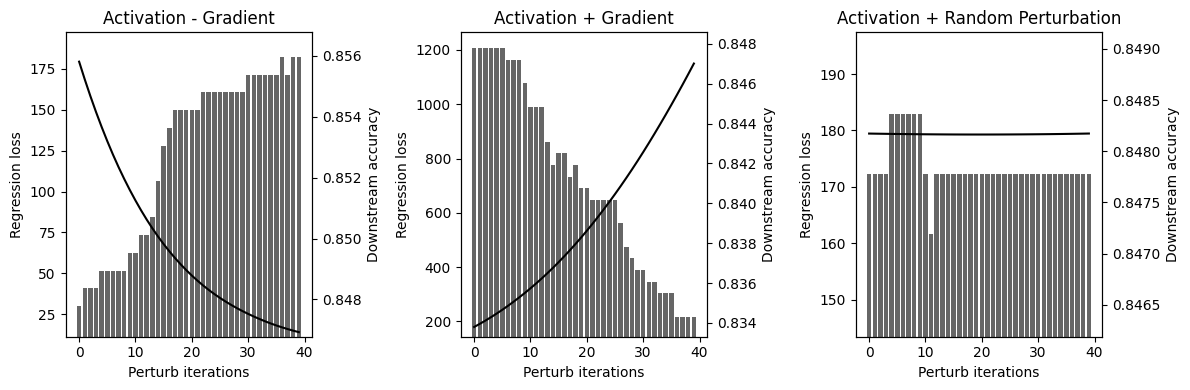

In [40]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
dic = {'Activation - Gradient': (l, acc),
       "Activation + Gradient": (l_inc, acc_inc),
       "Activation + Random Perturbation": (l_rand, acc_rand)}
for ax1, (label, (ls, a)) in zip(axs, dic.items()):
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


    color = 'black'
    ax1.set_xlabel('Perturb iterations')
    ax1.set_ylabel('Regression loss', color=color)  # we already handled the x-label with ax1
    ax1.plot(range(40), ls,color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    # ax1.set_ylim(np.min(a),np.max(a))
    ax1.set_title(label)
    ax1.set_ylim(min(ls)*0.8, max(ls)*1.1)


    # color = 'tab:orange'
    ax2.set_ylabel('Downstream accuracy', color=color)
    # ax2.plot(range(40), acc, color=color, linestyle='--')
    ax2.bar(range(40), a, color='black',alpha=0.6)
    ax2.set_ylim(min(a) - 0.001, max(a)+0.0008)
    ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [60]:
# Conterfactual perturbation
e, t, m = d[1392685764]
tgt = torch.tensor((df.loc[1392685764, ['lat','lng']].values.astype(np.float32)), dtype=torch.float32)
inp = {'last_hidden_state':e.view(1,-1,2048),
       'mask':m.view(1,-1),
       'input_ids':t.view(1,-1),
       'coord':tgt.view(1,-1)}
# reg.compute_loss(inp)
# reg.to(device)
# reg(inp['last_hidden_state'].to(device), inp['mask'].to(device))
e = torch.unsqueeze(e, 0)

In [62]:
pert = Perturber(reg=reg, cls=clf, device=device)
tgt = torch.tensor([-34.5997,-58.3819], dtype=torch.float32)
x_pert = pert.perturb_sample(e, m.view(1,-1), tgt.view(1,-1), epochs=400,lr=0.005)

21994.48046875
19383.66015625
16954.646484375
14709.9404296875
12647.083984375
10760.478515625
9123.28515625
7694.89892578125
6455.6748046875
5377.00341796875
4398.521484375
3586.44140625
2887.18603515625
2299.56103515625
1862.413818359375
1530.943359375
1276.9017333984375
1094.2845458984375
978.7129516601562
911.5956420898438
887.435791015625
883.9605712890625
891.3782348632812
901.2406616210938
908.3767700195312
908.9119873046875
898.8663940429688
876.7753295898438
842.7096557617188
799.0301513671875
747.1845092773438
689.6019897460938
637.84619140625
586.0513916015625
534.1895751953125
483.4965515136719
435.052001953125
389.7395324707031
348.2236022949219
310.9435119628906
278.11669921875
249.7527618408203
225.68006896972656
208.60047912597656
194.9309539794922
183.85423278808594
174.85415649414062
167.42562866210938
160.87451171875
154.726318359375
148.85414123535156
143.24496459960938
137.672119140625
132.14163208007812
127.31694030761719
122.37340545654297
117.38346862792969
112.

In [63]:
logit1=clf(inp)[0].detach()

inp['last_hidden_state'] = x_pert
inp['input_ids'] = torch.unsqueeze(t, 0)
logit2=clf(inp)[0].detach()

logit_diff=(logit1-logit2).detach().cpu().numpy()

In [64]:
# np.argsort(logit1.numpy()-logit2.numpy())
mp = {i:'' for i in range(100)}
for id in df_major.index.values:
    mp[df_major.loc[id, 'country_id'].astype(np.int64)] = df_major.loc[id, 'country']
for i in np.argsort(logit1.detach().cpu().numpy()-logit2.detach().cpu().numpy()):print(mp[i.item()])
# print(logit1-logit2)

Argentina
Brazil
Sri Lanka
Angola
Chile
Ghana
Ecuador
Zambia
South Africa
Nicaragua
Yemen
Nigeria
Sudan
Burkina Faso
Bolivia
Senegal
Azerbaijan
Paraguay
Uganda
Egypt
Madagascar
Colombia
New Zealand
Côte d'Ivoire
Mozambique
Kenya
Algeria
Benin
Zimbabwe
India
Cameroon
Greece
Haiti
Syria
Oman
Vietnam
Tanzania
Ethiopia
United States
Puerto Rico
Libya
Dominican Republic
Bosnia and Herzegovina
Russia
Canada
Germany
El Salvador
Turkey
Tunisia
Malaysia
Romania
Turkmenistan
Lebanon
Finland
Czechia
Sweden
Netherlands
Bulgaria
Guatemala
Peru
Belarus
Pakistan
Afghanistan
Congo (Kinshasa)
Indonesia
Venezuela
Jordan
Serbia
Cuba
Hungary
Morocco
Italy
France
Taiwan
Saudi Arabia
Australia
Guinea
Belgium
Israel
Somalia
Mexico
Ukraine
Iraq
Thailand
North Korea
Bangladesh
Poland
Iran
Kazakhstan
Nepal
Japan
Spain
United Kingdom
Myanmar
Portugal
Uzbekistan
Honduras
China
Philippines
South Korea


In [65]:
logit_diff=(logit1-logit2).detach().cpu().numpy()


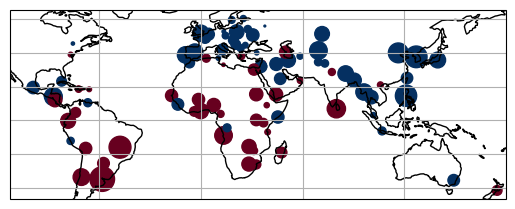

In [66]:
import cartopy.crs as ccrs

lat=[df_major[(df_major.country_id==i) & (df_major.capital=='primary')].lat.values[0] for i in range(100)]
lng=[df_major[(df_major.country_id==i) & (df_major.capital=='primary')].lng.values[0] for i in range(100)]
# x,y=np.linspace(-180,180,1000),np.linspace(-90,90,1000)
# z=griddata(np.array([[lg,lt] for lg,lt in zip(lng,lat)]), logit_diff, (x[None,:], y[:,None]),method='cubic',fill_value=1)
fig,ax=plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# c=ax.pcolormesh(x,y,z,cmap='RdBu', vmin=-5, vmax=5)
ax.scatter(lng,lat,s=np.abs(logit_diff)*40,c=np.sign(logit_diff),cmap='RdBu')
ax.coastlines()
ax.gridlines()

# fig.colorbar(c, ax=ax)

plt.show()

In [70]:
mp_c2id = {v: k for k, v in mp.items()}
cname = ['Cuba', 'Mexico','Brazil', 'Argentina', 'United Kingdom', 'China', 'Japan', 'South Korea', 'Chile', 'United States', 'Australia', 'New Zealand', 'Italy', 'Indonesia', 'Haiti', 'South Africa']
cid = [mp_c2id[n] for n in cname]
colors = np.random.rand(len(cid),3)


Text(0.5, 1.0, 'Activation + Random Perturbation')

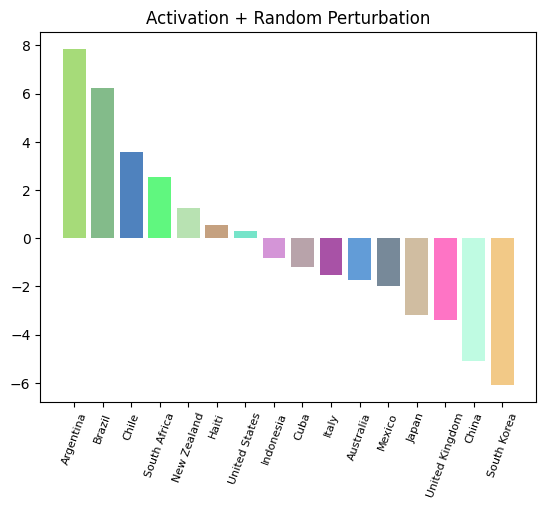

In [71]:
clogit = list(zip(cname, -logit_diff[cid],colors))
clogit.sort(key=lambda x: -x[1])
name = [x[0] for x in clogit]
# print(name)
l = [x[1] for x in clogit]
col = [x[2] for x in clogit]
plt.bar(range(len(l)), l, color=col, alpha=0.7)
plt.xticks(range(len(l)), labels=name, rotation=70, fontsize=8)
plt.title(label)


### Statistical Significance Test

In [ ]:
from collections import defaultdict, Counter



In [ ]:
labelo,labelp=[],[]

with torch.no_grad():
  samples = pert.perturbed_samples
  ko = set()
  for i, x in enumerate(val_loader):
    pred = clf.predict(x)
    for j in range(pred.shape[0]):
      if pred[j] != x['label'][j]:
        labelo.append(pred[j].item())
        ko.add(tuple(x['coord'][j].numpy()))

  for x in samples:
    pred = clf.predict(x)
    for j in range(pred.shape[0]):
      if tuple(x['coord'][j].numpy()) in ko:
        labelp.append(pred[j].item())
        # ko.add(tuple(x['coord'][j].numpy()))
    # labelp.append(clf.predict(x))
fo, fe=np.zeros(100), np.zeros(100)
for v in labelo:fo[v]+=1
for v in labelp: fe[v]+=1
fe = fe[np.nonzero(fe)]
fo = fo[np.nonzero(fo)]
chi2, p_value = chisquare(fe,fo)
chi2, p_value

(630.0166125784547, 3.139198200821253e-100)

(TtestResult(statistic=14.53173503532589, pvalue=3.386686307035478e-45, df=1707),
 ConfidenceInterval(low=0.10243751996982796, high=0.13440414374839563))

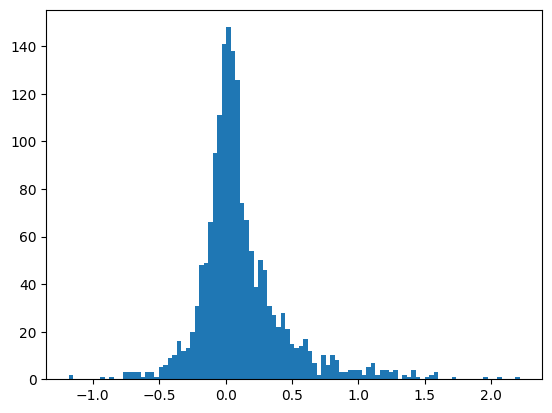

In [ ]:
from scipy.stats import ttest_1samp

# fo, fe=np.zeros(100), np.zeros(100)
# for v in obs:fo[v]+=1
# for v in expt: fe[v]+=1
# Perform the chi-square test
# chi2, p_value = fisher_exact(fo,fe)
# chi2, p_value
# res = ttest_1samp(list(dlogit),0)
# res.confidence_interval(.95)
dl_all = np.array(list(dl.values()))
plt.hist(dl_all, 100)
res = ttest_1samp(dl_all,0)
res, res.confidence_interval(.95)

In [ ]:
# dlogit = []
dl=defaultdict(float)
with torch.no_grad():
  samples = pert.perturbed_samples
  for i in range(len(samples)):
    labelp = torch.nn.functional.one_hot(samples[i]['label'],100)
    label=samples[i]['label']
    logit_pert = (clf(samples[i]).cpu()) * labelp

    for j in range(logit_pert.shape[0]):
      # cor=logit_pert[j,label[j]]
      # logit_pert[j,label[j]]=-100
      # chg= cor-logit_pert[j].max(-1)[0]
      k = tuple(samples[i]['coord'][j].numpy())
      # dl[k]=(chg-dl[k])/torch.abs(dl[k])
      dl[k] += logit_pert[j].sum() #(logit_pert[j].sum() -dl[k])/dl[k]


  for i, x in enumerate(list(val_loader)):
    labelo = torch.nn.functional.one_hot(x['label'],100)

    logit_ori = (clf(x).cpu()) * labelo

    for j in range(logit_ori.shape[0]):
      # if torch.argmax(logit_ori[j]) == x['label'][j]:continue
      # dlogit.append(dl[tuple(x['coord'][j].numpy())] - logit_ori[j, x['label'][j]])

      # cor=logit_ori[j,x['label'][j]]
      # logit_ori[j,x['label'][j]]=-100
      # chg= cor-logit_ori[j].max(-1)[0]
      dl[tuple(x['coord'][j].numpy())]-= logit_ori[j].sum()

    # dlogit.append(logit_pert.sum(1)-logit_ori.sum(1))

  # for i in range(len(samples)):
  #   labelp = torch.nn.functional.one_hot(samples[i]['label'],100)
  #   label=samples[i]['label']
  #   logit_pert = (clf(samples[i]).cpu()) * labelp

  #   for j in range(logit_pert.shape[0]):
  #     # cor=logit_pert[j,label[j]]
  #     # logit_pert[j,label[j]]=-100
  #     # chg= cor-logit_pert[j].max(-1)[0]
  #     k = tuple(samples[i]['coord'][j].numpy())
  #     # dl[k]=(chg-dl[k])/torch.abs(dl[k])
  #     dl[k] += logit_pert[j].sum() #(logit_pert[j].sum() -dl[k])/dl[k]

# dlogit=np.array([x.item() for x in dlogit])
# dl


(array([ 2.,  0.,  0.,  0.,  1.,  0.,  2.,  1.,  1.,  5.,  9., 21., 50.,
        31., 18., 12., 18., 13., 16., 10.,  9.,  3.,  4.,  4.,  5.,  3.,
         3.,  4.,  6.,  0.,  2.,  3.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,
         1.]),
 array([-0.91259766, -0.83834898, -0.76410025, -0.68985158, -0.61560285,
        -0.54135418, -0.46710548, -0.39285678, -0.31860811, -0.2443594 ,
        -0.1701107 , -0.09586201, -0.02161331,  0.05263538,  0.12688407,
         0.20113277,  0.27538148,  0.34963018,  0.42387885,  0.49812755,
         0.57237625,  0.64662492,  0.72087365,  0.79512233,  0.86937106,
         0.94361973,  1.0178684 ,  1.09211707,  1.16636586,  1.24061453,
         1.3148632 ,  1.38911188,  1.46336055,  1.53760934,  1.61185801,
         1.68610668,  1.76035535,  1.83460402,  1.90885282,  1.98310149,
         2.05735016]),
 <BarContainer object of 40 artists>)

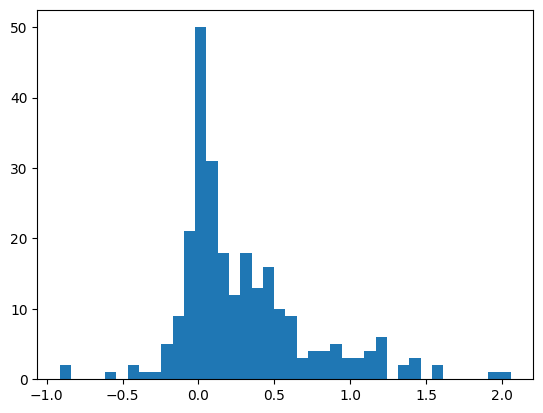

In [ ]:
plt.hist(dlogit, 40)

(0.13589354700450318,
 0.3384490412488969,
 -0.005309602974170265,
 0.2328362146208255,
 -0.17317263359766655,
 0.3759051356093157)

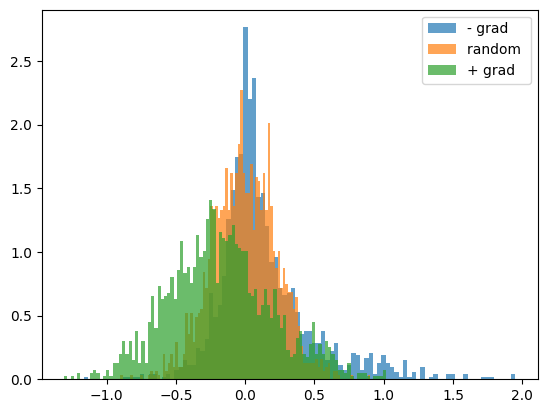

In [ ]:
cg_dec=[]
for v in dl.values():
  cg_dec.append(v.item())
cg_dec = np.array(cg_dec)
plt.hist(cg,100,alpha=0.7,density=True,label='- grad')
plt.hist(cg_rand,100,alpha=0.7,density=True,label='random ')
plt.hist(cg_dec,100,alpha=0.7,density=True,label='+ grad')
plt.legend()
# cg.mean(),cg.std()
cg.mean(),cg.std(),cg_rand.mean(),cg_rand.std(),cg_dec.mean(),cg_dec.std()

## RSA

In [72]:
n=100
rsm=np.identity(n)
ls_id=df_major.index.values
for i in range(n):
  emb1=d[ls_id[i]][0]
  for j in range(n):
    emb2=d[ls_id[j]][0]
    rsm[i][j]=scipy.stats.spearmanr(emb1.numpy().mean(0),emb2.numpy().mean(0)).statistic

rsm


array([[1.        , 0.81874493, 0.81773178, ..., 0.81016473, 0.83714818,
        0.89451015],
       [0.81874493, 1.        , 0.85722196, ..., 0.78991887, 0.77301143,
        0.83916575],
       [0.81773178, 0.85722196, 1.        , ..., 0.77370723, 0.80631036,
        0.84933857],
       ...,
       [0.81016473, 0.78991887, 0.77370723, ..., 1.        , 0.84289299,
        0.89453295],
       [0.83714818, 0.77301143, 0.80631036, ..., 0.84289299, 1.        ,
        0.83169   ],
       [0.89451015, 0.83916575, 0.84933857, ..., 0.89453295, 0.83169   ,
        1.        ]])

In [73]:
!pip install geopy

In [74]:
from geopy.distance import geodesic

rsmgeo=np.zeros_like(rsm)
for i in range(n):
  l1=df_major.iloc[i,2:4].values
  for j in range(n):
    l2=df_major.iloc[j,2:4].values
    rsmgeo[i][j]= geodesic(l1, l2).kilometers
rsmgeo=np.exp(-rsmgeo*1e-4)

In [76]:
tau=np.zeros(n)
for i in range(n):
  tau[i]=scipy.stats.kendalltau(rsm[i], rsmgeo[i]).statistic
tau.mean()

0.38410101010101017

In [ ]:
np.argsort(-tau)

array([76, 45, 90, 60, 43, 74, 38, 86, 34,  3, 16, 54, 50, 79, 51, 69, 99,
       72, 53, 80, 83, 85, 70, 95, 92, 37, 46, 78, 48, 84, 57, 42, 67, 94,
       56, 40, 68, 25, 47, 96, 93, 44, 71,  6, 58, 24, 30,  0, 89, 65, 32,
       13, 81, 15, 23, 39, 14, 91, 73, 26,  4, 10, 61, 59, 64, 66,  9, 88,
        8, 29, 31, 22, 82, 33, 77, 63, 21, 18, 12,  2, 11, 28, 52, 20, 41,
       55, 98,  5, 75, 19,  7, 35, 27, 17,  1, 87, 49, 36, 97, 62])

In [77]:
rsa_cnty = ['China', 'United States', 'India', 'Brazil',
       'Japan', 'Russia', 'Mexico', 'Turkey', 'United Kingdom',
       'Indonesia', 'Germany', 'Argentina', 'Iran',
      'Nigeria', 'Canada', 'South Korea', 'France', 'Egypt', 'Australia','Sweden']

In [79]:
n=len(rsa_cnty)
rsm,rsmcos, rsml2=np.identity(n),np.identity(n),np.identity(n)
cnty_enb = np.zeros((n,2048))
for i, name in enumerate(rsa_cnty):
  tmp=df_major[df_major.country == name]['id.1'].apply(lambda x: d[x][0].numpy()).values
  cnty_enb[i] = np.stack(tmp).mean((0,1))
for i in range(n):
  # emb1=d[ls_id[i]][0]
  for j in range(n):
    # emb2=d[ls_id[j]][0]
    rsm[i][j]=scipy.stats.spearmanr(cnty_enb[i],cnty_enb[j]).statistic
    rsmcos[i][j]=1-scipy.spatial.distance.correlation(cnty_enb[i],cnty_enb[j])
    rsml2[i][j]=scipy.spatial.distance.seuclidean(cnty_enb[i],cnty_enb[j],cnty_enb.std(0)**2)

# rsml2


In [84]:
tmp=np.exp(-rsml2**2*1e-4)

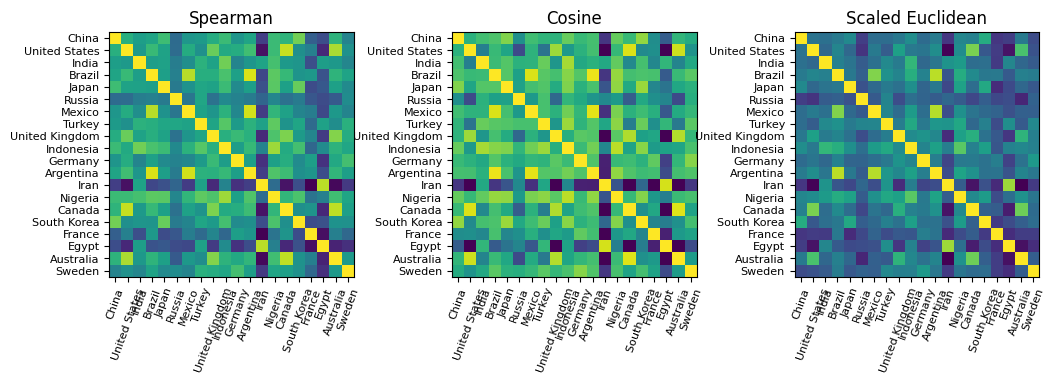

In [85]:
fig, axs=plt.subplots(1,3,figsize=(12,6))
metrics = ['Spearman', 'Cosine', 'Scaled Euclidean']
for i, (ax, d )in enumerate(zip(axs, [rsm, rsmcos, tmp])):
  clim = (0.85, 1) if i==1 else None
  im = ax.imshow(d, clim=clim)
  ax.set_xticks(range(n), rsa_cnty, fontsize=8, rotation=70)
  ax.set_yticks(range(n), rsa_cnty, fontsize=8,)
  ax.set_title(metrics[i])
# im1=ax1.imshow(rsm)
# im2=ax2.imshow(rsmcos, clim=(0.85, 1))
# im3=ax3.imshow(tmp)
# cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.04, pad=0.05)
# cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.04, pad=0.05)
# cbar3 = fig.colorbar(im3, ax=ax3, orientation='vertical', fraction=0.06, pad=0.05)
# plt.imshow(tmp)
# cbar = plt.colorbar()
# plt.xticks(range(n), rsa_cnty, rotation=70)
# plt.yticks(range(n), (rsa_cnty))
# plt.title('Spearman Correlation')
plt.subplots_adjust(wspace=0.4)
plt.show()

In [86]:
from geopy.distance import geodesic

rsmgeo=np.zeros_like(rsm)
for i in range(n):
  l1=df_major[df_major.country==rsa_cnty[i]].iloc[:,2:4].values.mean(0)
  for j in range(n):
    l2=df_major[df_major.country==rsa_cnty[j]].iloc[:,2:4].values.mean(0)
    rsmgeo[i][j]= geodesic(l1, l2).kilometers


Text(0.5, 1.0, 'Geographical distance')

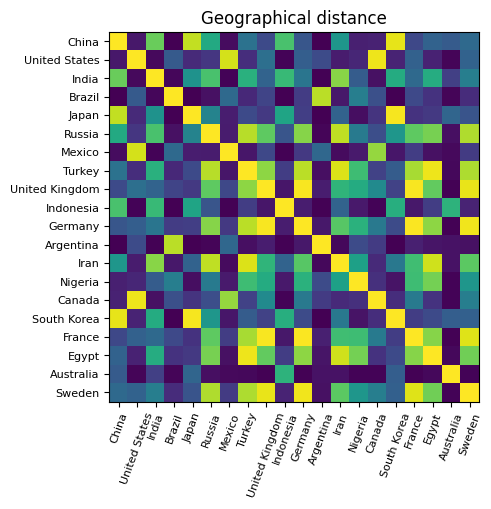

In [ ]:
plt.imshow(np.exp(-np.power(rsmgeo,2)*2e-8))
plt.xticks(range(n), rsa_cnty, fontsize=8, rotation=70)
plt.yticks(range(n), rsa_cnty, fontsize=8,)
plt.title("Geographical distance")
# im1=ax1.imshow(rsm)

In [91]:
# simgeo=rsmgeo
# simgeo=np.exp(-np.power(rsmgeo,2)*5e-6)
tau,p=np.zeros(n),np.zeros(n)
for i in range(n):
  res=scipy.stats.kendalltau(tmp[i], simgeo[i])
  tau[i],p[i]=res.statistic, res.pvalue
tau.mean(),p.mean()

(0.2130139079874816, 0.2730630057905554)

## Get Embeddings (Do not need to be run)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/6.8610_proj'
df = pd.read_csv(os.path.join(path, 'majorcities.csv'), index_col=0).dropna(subset='population')
df = df[df.population > 60000]

num_class = 100
major_cnty = df.groupby('country_id').count().sort_values('city', ascending=False).index.values[:num_class]
# np.argwhere(df.groupby('country_id').count().sort_values('city', ascending=False).city.values == 9)
df_major = df[df.country_id.isin(list(major_cnty))].drop_duplicates(['city', 'admin_name'])
df_major.admin_name = df_major.apply((lambda x: ", ".join([x.city, x.admin_name]) if type(x.admin_name)!=float else x.city), axis=1)
df_major[df_major.city=='London']

In [ ]:
# ls = [f"The latitude and longitude of city {n} is" for n in df_major.admin_name.values]
# tk = tokenizer(ls, truncation=True, max_length=32, pad_to_max_length=True, return_tensors='pt')
# torch.save(torch.tensor(df_major.index.values), '/content/drive/MyDrive/Colab Notebooks/6.8610_proj/cid.pt')
ids, token, masks, hiddens = [],[],[],[]
# # df_major = df_major.drop_duplicates(['city','admin_name'])
with torch.no_grad():
  for i in tqdm(range(0, len(df_major) , 64)):
      end = min(len(df_major), i+64)

      id = df_major.index.values[i:end]
      n = [f"The latitude and longitude of city {n} is" for n in df_major.loc[id].admin_name.values]
      # if type(adm) != float: n = ', '.join([n,adm])
      inputs = tokenizer(n, truncation=True, max_length=28, pad_to_max_length=True, return_tensors='pt').to(device)
      ids.append(id)
      token.append(inputs.input_ids.cpu())
      masks.append(inputs.attention_mask.cpu())
      h=model(**inputs, output_hidden_states=True).hidden_states
      hiddens.append((h[20].cpu(),h[24].cpu()))
      # hiddens.append(h[0].cpu())
      del inputs, h
#     j+=1
#     if j%1==0:print(j)
#     if i > 5:break

# embs, masks, tokens, ids
# res=embs[0]
# res.hidden_states[0]

In [ ]:
torch.save(torch.concat(ids,0), '/content/drive/MyDrive/Colab Notebooks/6.8610_proj/<filename>')
torch.save(torch.concat(tokens, 0), '/content/drive/MyDrive/Colab Notebooks/6.8610_proj/<filename>')
torch.save(torch.concat(masks, 0), '/content/drive/MyDrive/Colab Notebooks/6.8610_proj/<filename>')

for i in range(len(hiddens[0])):
  torch.save(torch.concat([x[i] for x in hiddens], 0), '/content/drive/MyDrive/Colab Notebooks/6.8610_proj/<filename>')

